# Model calibrations using ML

## Structure

- given files containing smiles and parameters, extract data
- train network map f: parameters -> smile
- pick smile, train network g: theta_0 -> theta_guess (theta being parameters)


## Authors

Dr. Blanka Horvath, Aitor Muguruza Gonzalez, Mehdi Tomas

## Extract data

In [15]:
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
f = gzip.GzipFile('Bergomi1FactorTrainSet.txt.gz', "r")
dat=np.load(f)
xx=dat[:,:4]
yy=dat[:,4:]
print(xx.shape)
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

(40000, 4)


In [17]:
xx[0,:4]

array([ 0.0575803,  2.53648  ,  3.38008  , -0.0976816])

# Scale and Normalize data

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    yy, xx, test_size=0.15, random_state=42)
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
scale2=  StandardScaler()
y_train_transform = scale.fit_transform(y_train)
y_test_transform = scale.transform(y_test)
x_train_transform = scale2.fit_transform(X_train)
x_test_transform = scale2.transform(X_test)

In [22]:
def xtransform(X_train,X_test):
    return [scale2.transform(X_train),scale2.transform(X_test)]

    
[x_train_transform,x_test_transform]=xtransform(X_train,X_test)

def xinversetransform(x):
    return scale2.inverse_transform(x)

In [24]:
ub=[0.16,4,10,0]
lb=[0.01,0.5,0,-1]
def myscale(x):
    res=np.zeros(4)
    for i in range(4):
        res[i]=(x[i] - (ub[i] + lb[i])*0.5) * 2 / (ub[i] - lb[i])
        
    return res
def myinverse(x):
    res=np.zeros(4)
    for i in range(4):
        res[i]=x[i]*(ub[i] - lb[i]) *0.5 + (ub[i] + lb[i])*0.5
        
    return res
    

In [26]:
y_train_transform = np.array([myscale(y) for y in y_train])
y_test_transform = np.array([myscale(y) for y in y_test])

In [28]:
y_test_transform.shape

(6000, 4)

# Create the Neural Network

In [34]:
import keras
from keras.layers import Activation
import tensorflow as tf 
import tensorflow.keras.backend as K
from keras.utils import get_custom_objects
keras.backend.set_floatx('float64')
input1 = keras.layers.Input(shape=(4,))
x1 = keras.layers.Dense(30,activation = 'elu')(input1)
x2=keras.layers.Dense(30,activation = 'elu')(x1) 
x3=keras.layers.Dense(30,activation = 'elu')(x2) 


x4=keras.layers.Dense(88,activation = 'linear')(x3)


modelGEN = keras.models.Model(inputs=input1, outputs=x4)
modelGEN.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 88)             │         2,728 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,738 (37.02 KB)

 Trainable params: 4,738 (37.02 KB)

 Non-trainable params: 0 (0.00 B)

# Fit the Neural Network (No need to run the code, parameters are stored on a .h5 file)

In [21]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
modelGEN.compile(loss = root_mean_squared_error, optimizer = "adam")

modelGEN.fit(y_train_transform, x_train_transform, batch_size=32,validation_data = (y_test_transform,x_test_transform),epochs = 200, verbose = True,shuffle=1)#,callbacks=[earlystop])

Epoch 1/200
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step - loss: 0.3396 - val_loss: 0.0959
Epoch 2/200
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 0.0790 - val_loss: 0.0479
Epoch 3/200
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 0.0458 - val_loss: 0.0367
Epoch 4/200
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 0.0368 - val_loss: 0.0314
Epoch 5/200
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 0.0317 - val_loss: 0.0279
Epoch 6/200
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 0.0292 - val_loss: 0.0257
Epoch 7/200
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 0.0267 - val_loss: 0.0251
Epoch 8/200
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 0.0254 - val_loss: 0.0240
Epoch 9/200
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 0.0236 - val_loss: 0.0218
Epoch 10/200
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 0.0224 - val_loss: 0.0207
Epoch 11/200
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 0.0217 - val_loss: 0.01

## Store/Load optimal NN parameteres

In [36]:
modelGEN.save_weights('1FBergomiNN.weights.h5')

In [38]:
modelGEN.load_weights('1FBergomiNN.weights.h5')

In [40]:
NNParameters=[]
for i in range(1,len(modelGEN.layers)):
    NNParameters.append(modelGEN.layers[i].get_weights())

# Numpy Implementation of the Neural Network tends to be faster than Keras

In [42]:
NumLayers=3
def elu(x):
    #Careful function ovewrites x
    ind=(x<0)
    x[ind]=np.exp(x[ind])-1
    return x
def eluPrime(y):
    # we make a deep copy of input x
    x=np.copy(y)
    ind=(x<0)
    x[ind]=np.exp(x[ind])
    x[~ind]=1
    return x
def NeuralNetwork(x):
    input1=x
    for i in range(NumLayers):
        input1=np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
        #Elu activation
        input1=elu(input1)
    #The output layer is linnear
    i+=1
    return np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
def NeuralNetworkGradient(x):
    input1=x
    #Identity Matrix represents Jacobian with respect to initial parameters
    grad=np.eye(4)
    #Propagate the gradient via chain rule
    for i in range(NumLayers):
        input1=(np.dot(input1,NNParameters[i][0])+NNParameters[i][1])
        grad=(np.einsum('ij,jk->ik', grad, NNParameters[i][0]))
        #Elu activation
        grad*=eluPrime(input1)
        input1=elu(input1)
    #input1.append(np.dot(input1[i],NNParameters[i+1][0])+NNParameters[i+1][1])
    grad=np.einsum('ij,jk->ik',grad,NNParameters[i+1][0])
    #grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad
        

# Numpy gives 20 fold speed up

In [38]:
%timeit NeuralNetwork(y_train_transform[0])

8.49 μs ± 152 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [39]:
%timeit modelGEN.predict(y_train_transform[0].reshape(1,4))[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

In [44]:
%timeit NeuralNetworkGradient(y_train_transform[0])

24.9 μs ± 94.3 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Compute Implied vol relative errors on Test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

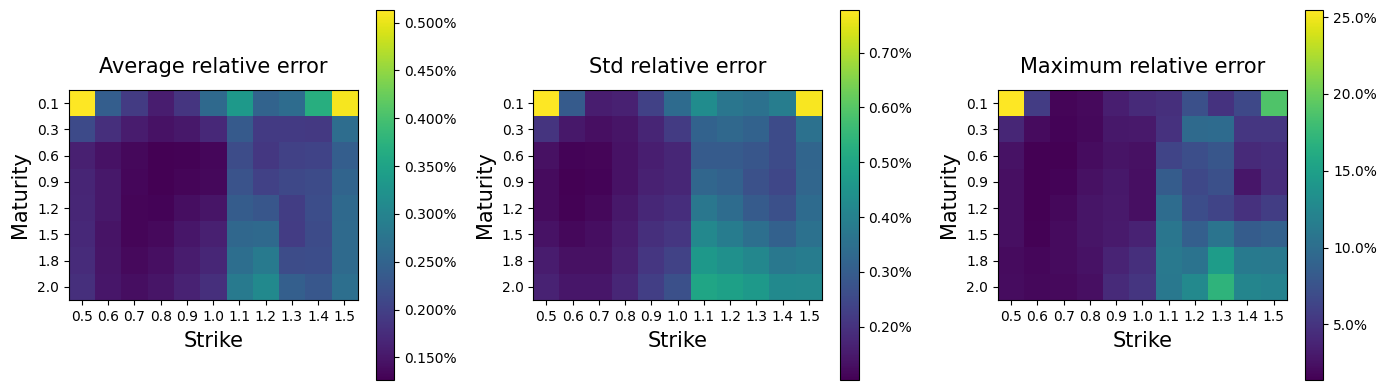

In [60]:
import numpy as np
import csv
S0=1.
strikes_dim=len(strikes)
maturities_dim=len(maturities)
strikeslabel=np.round(np.linspace(strikes[0],strikes[-1],8),1)
maturitieslabel=np.array([0.1,0.2, 0.6, 1.5,1.8])
##### AVERAGE VALUES #######
X_sample = xinversetransform(x_test_transform)
y_sample = y_test_transform

prediction=[xinversetransform(modelGEN.predict(y_sample[i].reshape(1,4)))[0] for i in range(len(y_sample))]
plt.figure(1,figsize=(14,4))
ax=plt.subplot(1,3,1)
err = np.mean(100*np.abs((X_sample-prediction)/X_sample),axis = 0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,2)
err = 100*np.std(np.abs((X_sample-prediction)/X_sample),axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,3)
err = 100*np.max(np.abs((X_sample-prediction)/X_sample),axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.tight_layout()
plt.savefig('1FBergomiNNErrors.png', dpi=300)
plt.show()

# Plot sample Smiles

y_sample shape (before inverse transform): (1, 4)
y_sample inverse transform: [[ 0.066285    2.28805697  2.07078694 -0.38918745]]
X_sample shape: (88,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Prediction shape: (88,)


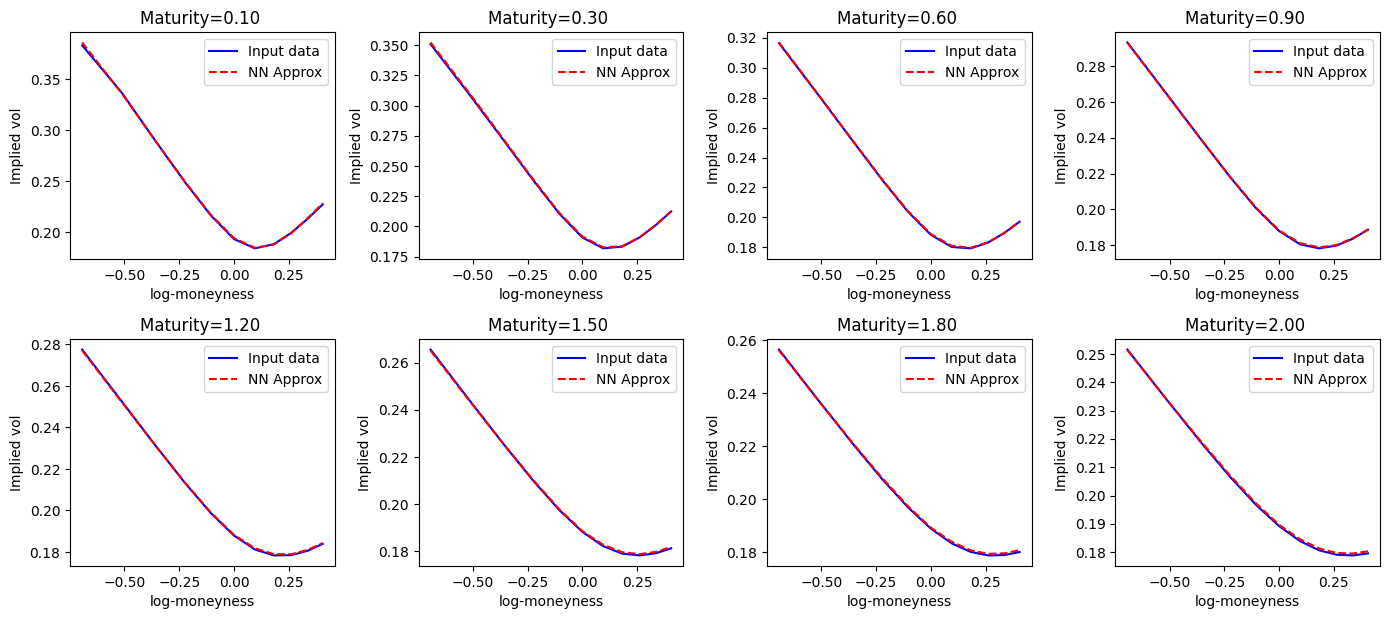

In [89]:
import matplotlib.pyplot as plt
import numpy as np

S0 = 1.
sample_ind = 125

# Ensure correct shapes
X_sample = X_test[sample_ind].reshape(-1)
y_sample = y_test_transform[sample_ind].reshape(1, -1)  # Ensure 2D for inverse transform

# Print debug info
print("y_sample shape (before inverse transform):", y_sample.shape)
print("y_sample inverse transform:", scale.inverse_transform(y_sample))
print("X_sample shape:", X_sample.shape)

# Predict and reshape correctly
prediction = xinversetransform(modelGEN.predict(y_sample)).reshape(-1)
print("Prediction shape:", prediction.shape)

# Plotting
plt.figure(1, figsize=(14, 12))
for i in range(maturities_dim):
    plt.subplot(4, 4, i + 1)
    
    plt.plot(np.log(strikes/S0), X_sample[i*strikes_dim:(i+1)*strikes_dim], 'b', label="Input data")
    plt.plot(np.log(strikes/S0), prediction[i*strikes_dim:(i+1)*strikes_dim], '--r', label="NN Approx")

    plt.title("Maturity=%1.2f "% maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    plt.legend()

plt.tight_layout()
plt.show()

# Use gradient methods for optimization

In [8]:
def CostFunc(x,sample_ind):
    return np.sum(np.power((NeuralNetwork(x)-x_test_transform[sample_ind]),2))
def Jacobian(x,sample_ind):
    return 2*np.sum((NeuralNetwork(x)-x_test_transform[sample_ind])*NeuralNetworkGradient(x),axis=1)
#Cost Function for Levenberg Marquardt
def CostFuncLS(x,sample_ind):
    return (NeuralNetwork(x)-x_test_transform[sample_ind])
def JacobianLS(x,sample_ind):
    return NeuralNetworkGradient(x).T

In [44]:
import time
import scipy
Approx = []
Timing = []
sample_ind = 500
X_sample = X_test[sample_ind]
y_sample = y_test_transform[sample_ind]
solutions = np.zeros([4, 4])
times = np.zeros(4)
init = np.zeros(4)

for i in range(5000):
    disp = f"{i+1}/5000"
    print(disp, end="\r")

    # L-BFGS-B
    start = time.perf_counter()
    I = scipy.optimize.minimize(CostFunc, x0=init, args=i, method='L-BFGS-B', jac=Jacobian, tol=1E-10, options={"maxiter": 5000})
    end = time.perf_counter()
    solutions[0, :] = myinverse(I.x)
    times[0] = end - start

    # SLSQP
    start = time.perf_counter()
    I = scipy.optimize.minimize(CostFunc, x0=init, args=i, method='SLSQP', jac=Jacobian, tol=1E-10, options={"maxiter": 5000})
    end = time.perf_counter()
    solutions[1, :] = myinverse(I.x)
    times[1] = end - start

    # BFGS
    start = time.perf_counter()
    I = scipy.optimize.minimize(CostFunc, x0=init, args=i, method='BFGS', jac=Jacobian, tol=1E-10, options={"maxiter": 5000})
    end = time.perf_counter()
    solutions[2, :] = myinverse(I.x)
    times[2] = end - start

    # Levenberg-Marquardt
    start = time.perf_counter()
    I = scipy.optimize.least_squares(CostFuncLS, init, JacobianLS, args=(i,), gtol=1E-10)
    end = time.perf_counter()
    solutions[3, :] = myinverse(I.x)
    times[3] = end - start

    # Store results
    Approx.append(np.copy(solutions))
    Timing.append(np.copy(times))

In [46]:
Approx[:][3]

array([[0.39711374, 8.77786265, 1.76137747, 1.27820627],
       [0.39711361, 8.77786048, 1.76137902, 1.27820564],
       [0.39711372, 8.77786187, 1.76137685, 1.27820618],
       [0.39710799, 8.77753117, 1.76120073, 1.27805578]])

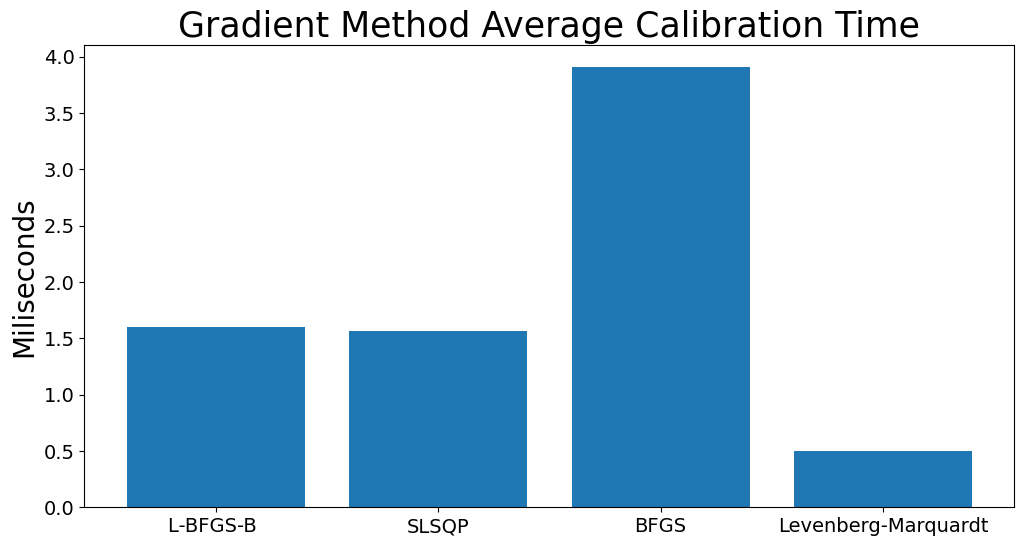

In [100]:
methods=["L-BFGS-B ","SLSQP","BFGS","Levenberg-Marquardt"]
plt.figure(1,figsize=(12,6))
plt.bar(methods,np.mean(Timing,axis=0)*1000)
plt.title("Gradient Method Average Calibration Time",fontsize=25)
plt.ylabel("Miliseconds",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

# Save the Lavenberg-Marquardt Optimal parameters

In [102]:
LMParameters=[Approx[i][3] for i in range(len(Approx))]
np.savetxt("NNParameters1FBergomi.txt",LMParameters)  

# Calibration Errors with Levenberg-Marquardt

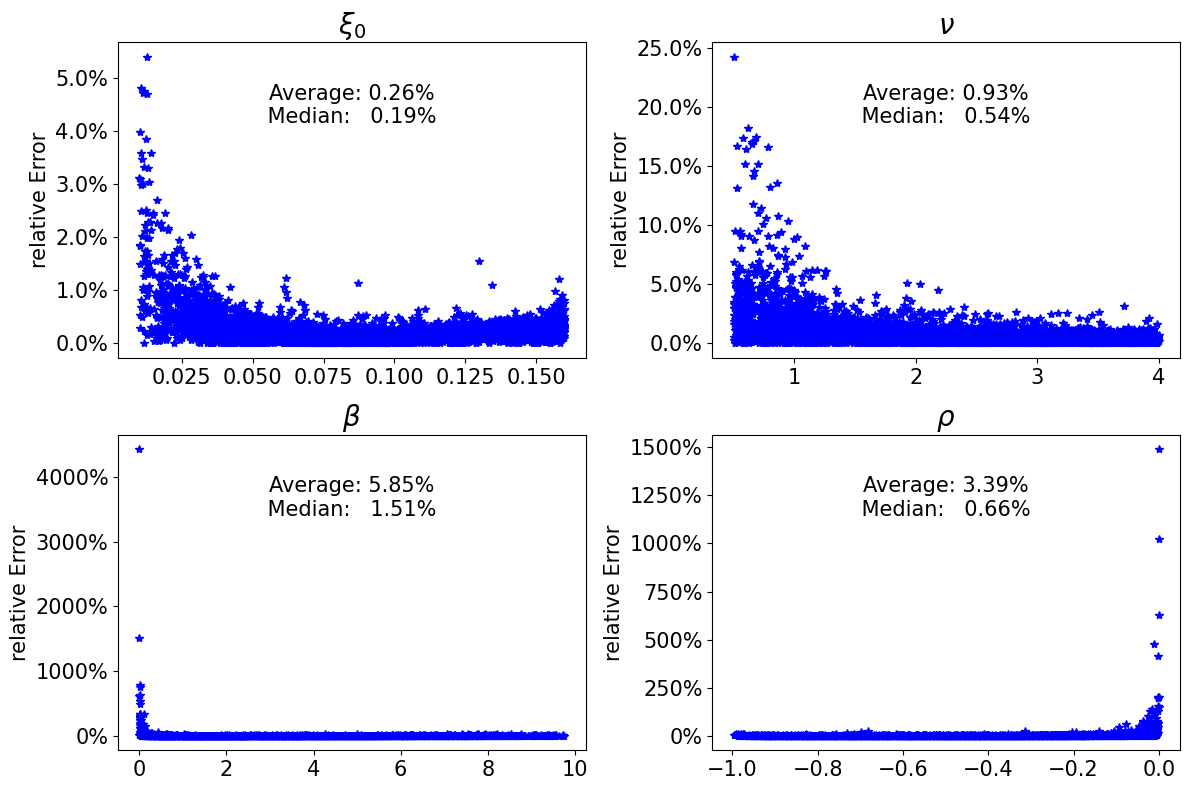

In [106]:
titles=["$\\xi_0$","$\\nu$","$\\beta$","$\\rho$"]
average=np.zeros([4,5000])
fig=plt.figure(figsize=(12,8))
for u in range(4):
    ax=plt.subplot(2,2,u+1)
    for i in range(5000):
        
        y=y_test[i][u]
        plt.plot(y,100*np.abs(LMParameters[i][u]-y)/np.abs(y),'b*')
        average[u,i]=np.abs(LMParameters[i][u]-y)/np.abs(y)
    plt.title(titles[u],fontsize=20)
    plt.ylabel('relative Error',fontsize=15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(100*average[u,:]),np.quantile(100*average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)

plt.tight_layout()
plt.savefig('1FBergomiParameterRelativeErrors.png', dpi=300)
plt.show()